#### Использованные модули:
- grequests
- requests
- pandas

In [1]:
import grequests as gr
import requests as r
import pandas as p

#### Использованные lambda функции
- `get_response_params` - получить словарь параметров для запроса
- `get_max_page` - получить последнюю доступную страницу для запроса

In [2]:
base_url = 'https://api.hh.ru'
vacancies_get_url = base_url + '/vacancies'

get_response_params = lambda page, keyword: {
    'text': keyword,
    'per_page': 100,
    'page': page,
    'only_with_salary': True,
    'currency': 'RUR'
}
get_clusters_response_params = lambda keyword: {
    'text': keyword,
    'per_page': 0,
    'only_with_salary': True,
    'currency': 'RUR',
    'clusters': True
}

get_max_page = lambda keyword: r.get(vacancies_get_url, params=get_response_params(1, keyword)).json()['pages']

#### Списки
- `keywords` содержит все ключевые слова/фразы, по которым будет происходить поиск
- `clusters_id` - содержит все id доступных кластеров

In [3]:
keywords = [
    'PHP',
    'Python',
    'Социолог',
    'Бухгалтер',
    'Разработчик',
    'Тестировщик'
]
clusters_id = [
    'area',
    'professional_area',
    'industry',
    'salary',
    'experience',
    'employment',
    'schedule'
]

#### Универсальные списки и словари для работы
- `max_pages` - номер последней доступной страницы для каждого ключевого слова/фразы
- `all_responses_data` - все данные для запуска всех запросов
- `all_responses_clasters` - все данные для запуска запросов получения кластеров
- `items` - содержит все собранные данные для каждого ключевого слова/фразы
- `items_data` - содержит всю собранную информацию по каждому ключевому слову/фразе
- `clusters_data` - содержит все собранные кластеры

In [4]:
max_pages = {keyword: get_max_page(keyword) for keyword in keywords}
all_responses_data = {
    keyword: {
        'url': vacancies_get_url, 
        'data': [get_response_params(p, keyword) for p in range(max_pages[keyword])]
    } for keyword in keywords
}
all_responses_clasters = {
    keyword: {
        'url': vacancies_get_url, 
        'data': get_clusters_response_params(keyword)
    } for keyword in keywords
}

In [5]:
items = {keyword: [] for keyword in keywords}
items_data = {
    keyword: {
        'salary': {
            'from': None,
            'to': None
        }
    } for keyword in keywords
}
clusters_data = {}

#### Справка
- `send_response` отправляем все запросы для каждого ключевого слова/фразы по отдельности
- `send_clasters_response` отправляем все запросы на получение кластера для каждого ключевого слова/фразы по отдельности
- `save_response_data` сохраняем полученные из запросов данные в удобном для нас формате
- `save_clasters_response_data` сохраняем полученные из запросов на получение кластера данные в удобном для нас формате
- `count_salary` - считаем среднюю зарплату
- `main` - точка входа в программу

In [6]:
def send_response(keyword: str) -> list|None:
    response = (
        gr.get(
            all_responses_data[keyword]['url'], 
            data=data
        ) for data in all_responses_data[keyword]['data']
    )
    return gr.map(response)


def send_clasters_response(keyword: str) -> list|None:
    response = [
        gr.get(
            all_responses_clasters[keyword]['url'], 
            data=all_responses_clasters[keyword]['data']
        )
    ]
    return gr.map(response)


def save_response_data(results: list, keyword: str):
    for result in results:
        data = result.json()
        for item in data['items']:
            if item['salary'] is None:
                continue
            items[keyword].append({
                'name': item['name'],
                'salary': {
                    'from': item['salary']['from'],
                    'to': item['salary']['to']
                }
            })


def save_clasters_response_data(results: list, keyword: str):
    data = results[0].json()
    
    clusters_data[keyword] = {}

    for cluster in data['clusters']:
        cluster_id = cluster['id']
        
        if cluster_id in clusters_id:
            clusters_data[keyword][cluster_id] = {}
            clusters_data[keyword][cluster_id]['name'] = cluster['name']
            clusters_data[keyword][cluster_id]['items'] = []
            
            for item in cluster['items'][:5]:
                clusters_data[keyword][cluster_id]['items'].append({
                    'name': item['name'],
                    'count': round(item['count'] / data['found'] * 100)
                })


def count_salary(keyword: str):
    sr_from = 0
    sr_to = 0
    for item in items[keyword]:
        if item['salary']['from'] is not None:
            sr_from += item['salary']['from']

        if item['salary']['to'] is not None:
            sr_to += item['salary']['to']

        if item['salary']['from'] is not None and item['salary']['to'] is None:
            sr_to += item['salary']['from']

    items_count = len(items[keyword])
    items_data[keyword]['salary']['from'] = round(sr_from/items_count)
    items_data[keyword]['salary']['to'] = round(sr_to/items_count)

    
def main():
    for keyword in keywords:
        print(f'\nKeywoard=<{keyword}>')

        results = send_response(keyword)
        save_response_data(results, keyword)
        
        result = send_clasters_response(keyword)
        save_clasters_response_data(result, keyword)

        print(f'items founded=<{len(items[keyword])}>')
        count_salary(keyword)

In [7]:
main()


Keywoard=<PHP>
items founded=<2000>

Keywoard=<Python>
items founded=<2000>

Keywoard=<Социолог>
items founded=<249>

Keywoard=<Бухгалтер>
items founded=<2000>

Keywoard=<Разработчик>
items founded=<2000>

Keywoard=<Тестировщик>
items founded=<1243>


In [8]:
p.set_option('display.max_rows', None)
data = p.DataFrame(
    {
        'Ключевое слово поиска': [
            keyword 
                for keyword in keywords 
                    for cluster_id in clusters_data[keyword].keys()
                        for _ in range(len(clusters_data[keyword][cluster_id]['items']))
        ],
        'Название кластера': [
            clusters_data[keyword][cluster_id]['name'] 
                for keyword in keywords 
                    for cluster_id in clusters_data[keyword].keys()
                        for _ in range(len(clusters_data[keyword][cluster_id]['items']))
        ],
        'Название категории': [
            cluster['name'] 
                for keyword in keywords 
                    for cluster_id in clusters_data[keyword].keys()
                        for cluster in clusters_data[keyword][cluster_id]['items']
        ],
        'Кол-во вакансий в категории': [
            str(cluster['count']) + '%'
                for keyword in keywords 
                    for cluster_id in clusters_data[keyword].keys()
                        for cluster in clusters_data[keyword][cluster_id]['items']
        ]
    }
)
data

,Ключевое слово поиска,Название кластера,Название категории,Кол-во вакансий в категории
0,PHP,Регион,Россия,91%
1,PHP,Регион,Москва,27%
2,PHP,Регион,Санкт-Петербург,13%
3,PHP,Регион,Новосибирская область,4%
4,PHP,Регион,Свердловская область,4%
5,PHP,Уровень дохода,от 75000 руб.,80%
6,PHP,Уровень дохода,от 150000 руб.,49%
7,PHP,Уровень дохода,от 225000 руб.,20%
8,PHP,Уровень дохода,от 300000 руб.,9%
9,PHP,Уровень дохода,от 375000 руб.,3%


In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [12]:
plots_data = [
    {
        'title': 'Самые популярные профобласти\nдля каждого ключевого слова/фразы',
        'xlabel': 'Кол-во, %',
        'salary_id': 'professional_area',
        'value_function': None,
        'use_name_as_value': False,
        'add_cluster_name_to_plot': True,
        'split_by_space': True
    },
    {
        'title': 'Самые популярные отрасли компаний\nдля каждого ключевого слова/фразы',
        'xlabel': 'Кол-во, %',
        'salary_id': 'industry',
        'value_function': None,
        'use_name_as_value': False,
        'add_cluster_name_to_plot': True,
        'split_by_space': True
    },
    {
        'title': 'Самый популярный уровень дохода\nдля каждого ключевого слова/фразы',
        'xlabel': None,
        'salary_id': 'salary',
        'value_function': lambda v: int(v.replace('от ', '').replace(' руб.', '')),
        'use_name_as_value': True,
        'add_cluster_name_to_plot': False,
        'split_by_space': True
    }
]

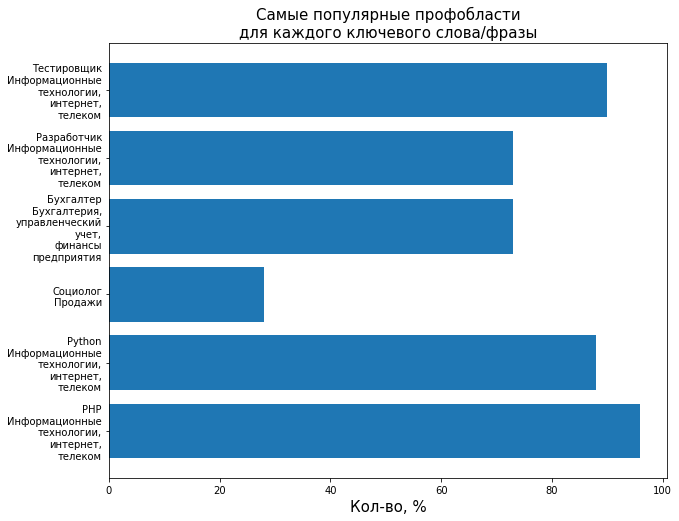

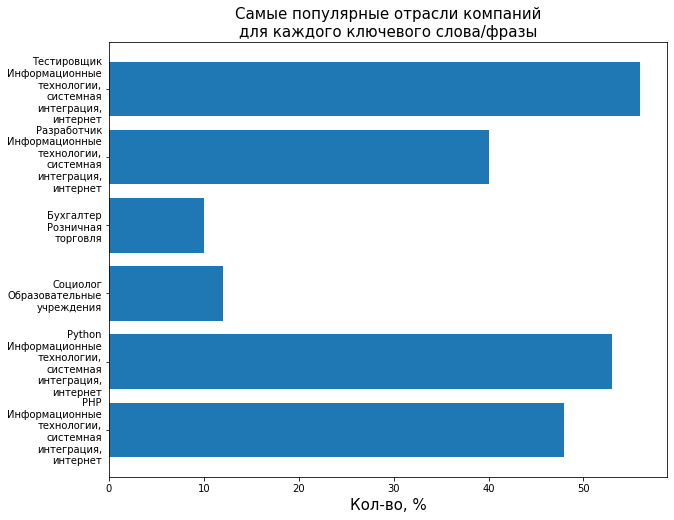

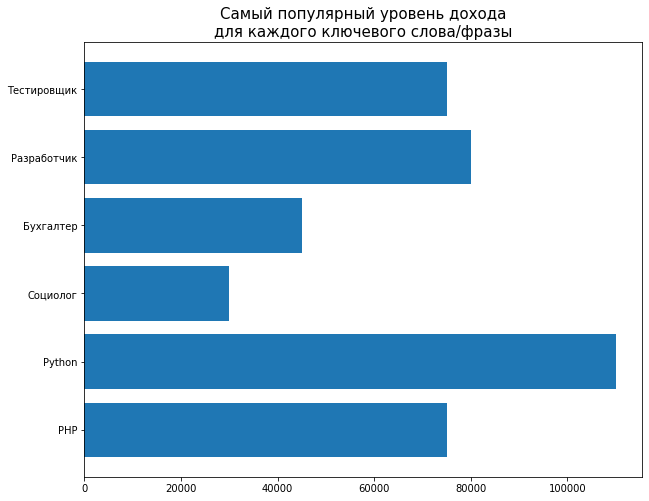

In [13]:
def generate_plot_data(
            salary_id: str, 
            value_function: callable, 
            use_name_as_value: bool, 
            add_cluster_name_to_plot: bool, 
            split_by_space: bool
        ):
    data = {'names': [], 'values': []}
    for keyword in keywords:
        cluster_name = clusters_data[keyword][salary_id]['items'][0]['name']
        cluster_count = clusters_data[keyword][salary_id]['items'][0]['count']
        
        name = f'{keyword}\n{cluster_name}' if add_cluster_name_to_plot else keyword
        data['names'].append(name.replace(' ', '\n') if split_by_space else name)

        value = cluster_name if use_name_as_value else cluster_count
        if value_function:
            value = value_function(value)
        data['values'].append(value)
    return data

for plot_data in plots_data:
    data = generate_plot_data(
        plot_data['salary_id'], 
        plot_data['value_function'],
        plot_data['use_name_as_value'],
        plot_data['add_cluster_name_to_plot'],
        plot_data['split_by_space']
    )
    
    plt.figure(figsize=(10,8))
    plt.title(plot_data['title'], fontsize=15)
    if plot_data['xlabel']:
        plt.xlabel(plot_data['xlabel'], fontsize=15)
    plt.barh(data['names'], data['values'], align = 'center')

<AxesSubplot:>

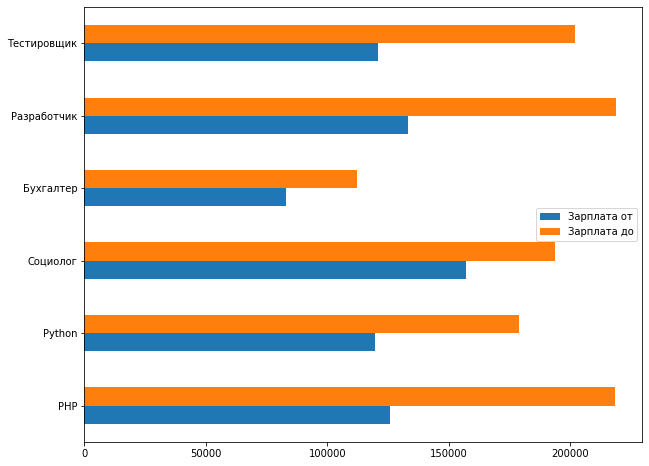

In [37]:
salary_form = []
salary_to = []

for keyword in keywords:
    salary_form.append(items_data[keyword]['salary']['from'])
    salary_to.append(items_data[keyword]['salary']['to'])

df = p.DataFrame({'Зарплата от': salary_form, 'Зарплата до': salary_to}, index=keywords)
df.plot.barh(figsize=(10,8))